In [2]:
import numpy as np
import pandas as pd
import spacy

## 答えたい問い
- 小説を中身を読まずして内容を推察することはできるのか？
  - テキスト情報を何らか可視化することで内容を推察していく
    - word cloudで単語の多く出現している単語を調べる
    - 出現頻度の多い語やWCで見つかったキーワードっぽい言葉との共起ネットワークから，内容を推察する
  - 最終的にデスクリサーチで取り上げる小説の内容の要約と自身の作成した要約の類似度を計算する
    - sentence2vec + consine similarityとかか
- 

In [3]:
# 読み込む小説のDL
!curl -O https://www.aozora.gr.jp/cards/000096/files/2093_ruby_28087.zip # ドグラマグラ(読むと精神に支障をきたす→真正面から読むべきではない本として)
!curl -O https://www.aozora.gr.jp/cards/000009/files/8_ruby_31219.zip # シャーロックホームズシリーズ「赤毛連盟」（読まずに犯人を見破れるか？の実験として）

# textフォルダ作る
!mkdir -p text
# ファイルをtextフォルダに解凍
!unzip -d text -o 2093_ruby_28087.zip
!unzip -d text -o 8_ruby_31219.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  411k  100  411k    0     0  2594k      0 --:--:-- --:--:-- --:--:-- 3050k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3341k  100 3341k    0     0  7820k      0 --:--:-- --:--:-- --:--:-- 7880k
Archive:  2093_ruby_28087.zip
Made with MacWinZipper™
  inflating: text/dogura_magura.txt  
Archive:  8_ruby_31219.zip
  inflating: text/akage_renmei.txt   
  inflating: text/fig8_01.png        
  inflating: text/fig8_02.png        
  inflating: text/fig8_03.png        
  inflating: text/fig8_04.png        
  inflating: text/fig8_05.png        
  inflating: text/fig8_06.png        
  inflating: text/fig8_07.png        
  inflating: text/fig8_08.png        
  inflating: text/fig8_09.png        
  inflating: text/fig8_10.p

In [4]:
# 青空文庫の記法を削除する

import re

input_fn = "text/dogura_magura.txt"
output_fn = "text/dogura_magura.stripruby.txt"

with open(input_fn, encoding="shift_jis") as fin, open(output_fn, mode="w") as fout:
    for line in fin:
        fout.write(re.sub(r"《[^》]+》|［[^］]+］|〔[^〕]+〕| [｜]", "", line))

In [5]:
import sys

# いらないところ(本の前書きとか最後の参考情報とか)を取り除く
if sys.platform == "darwin":
    !brew install coreutils
    !tail -n +45 text/dogura_magura.stripruby.txt | ghead -n -18 > text/dogura_magura.corpus.txt
else:
    !tail -n +45 text/dogura_magura.stripruby.txt | head -n -18 > text/dogura_magura.corpus.txt

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
acronym                    legba                      ruby@3.3
atac                       libesedb                   runitor
bender                     libformfactor              s5cmd
cargo-dist                 libgit2@1.8                sentry-cli
cargo-flamegraph           libheinz                   serie
cargo-msrv                 libkeyfinder               sfml@2
cargo-public-api           lol-html                   showcert
cargo-shuttle              ltex-ls-plus               slumber
codesnap                   malcontent                 static-web-server
codevis                    mdz                        streamrip
gh-ost                     monocle                    swc
ghc@9.10               

In [6]:
import spacy

input_fn = "text/dogura_magura.corpus.txt"
output_fn = "text/dogura_magura.wakati.txt"

nlp = spacy.load("ja_ginza")

with open(input_fn, "r") as fin, open(output_fn, "w") as fout:
    for line in fin:
        tokens = [token.text for token in nlp(line.rstrip())]
        fout.write(' '.join(tokens) + "\n") # 分かち書きを作成

In [7]:
# ファイルを読み込み、テキストを一行ずつ解析
all_tokens = [] # のちに分析対象となる単語たち
with open(input_fn, "r") as f:
    for line in f:
        tokens = [token for token in nlp(line)]
        all_tokens.extend(tokens)




  742 お
  686 博士
  673 中
  543 御座る
  480 おる
  478 思う
  477 正木
  438 眼
  438 呉
  417 行く
  389 時
  357 つ
  348 精神
  347 一郎
  345 若林
  345 脳髄
  344 上
  342 間
  340 吾輩
  320 前
  315 自分
  315 人間
  297 ところ
  285 先生
  277 頭
  273 考える
  258 しまう
  256 心理
  255 人
  250 顔
  248 研究
  246 得る
  244 方
  243 事件
  242 わかる
  228 まま
  225 うち
  220 処
  216 みる
  212 通り
  207 知る
  207 者
  199 かける
  196 年
  196 絵巻物
  194 記憶
  193 手
  187 今
  186 見える
  182 等


In [14]:
from collections import Counter

# 分析対象とする品詞（内容語 - 名詞、動詞、形容詞）と不要語（ストップワード）を指定する
# 要試行錯誤
include_pos = ("NOUN", "VERB", "ADJ", "PROPN")
stopwords = ("する", "ある", "ない", "いう", "もの", "こと", "よう", "なる", "ほう", "いる", "くる", "さん",
              "ゐる", "来る", "事", "見る", "御", "云ふ", "云う", "…", "―", "　") # 追加

# 単語の頻度を数える
counter = Counter(token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords)

# 出現頻度top 50を出力する
for word, count in counter.most_common(30):
    print(f"{count:>5} {word}")


  742 お
  686 博士
  673 中
  543 御座る
  480 おる
  478 思う
  477 正木
  438 眼
  438 呉
  417 行く
  389 時
  357 つ
  348 精神
  347 一郎
  345 若林
  345 脳髄
  344 上
  342 間
  340 吾輩
  320 前
  315 自分
  315 人間
  297 ところ
  285 先生
  277 頭
  273 考える
  258 しまう
  256 心理
  255 人
  250 顔


In [12]:
# よくわからないので品詞ごとにカウントをしていく
# まずは固有名詞から
include_pos = ("PROPN")
stopwords = ()

# 単語の頻度を数える
counter = Counter(token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords)

# 出現頻度top 50を出力する
print(len(counter))
for word, count in counter.most_common(50):
    print(f"{count:>5} {word}")

764
  476 正木
  356 呉
  347 一郎
  345 若林
  174 絵巻物
   64 斎藤
   52 八代
   45 若旦那
   41 呉家
   40 キチガイ
   40 福岡
   34 大正
   33 千世子
   31 九大
   28 直方
   27 モヨ
   26 日本
   25 黛
   22 ヘイ
   22 お金
   20 在る
   16 東京
   15 松原
   14 鏡太郎
   14 ドグラ・マグラ
   14 ドンナ
   13 支那
   13 十人
   13 喜三郎
   12 ヤット
   12 ウイスキー
   11 明治
   10 狂人
   10 ポカン
   10 福岡市
   10 汀
    9 馳
    9 儀作
    8 敬之
    8 チャン
    8 然れども
    8 野
    8 ヘイヘイ
    8 甘粕
    7 刹那
    7 経
    7 チョット
    7 タッタ
    7 ヘポメニアス
    7 雲井


In [21]:
# 次は動詞
include_pos = ("VERB")
stopwords = ("いる", "ある", "する", "なる", "いう", "来る", "見る", "御座る", "おる", "思う", "行く", "云う", "考える", "しまう", "得る", "わかる")

# 単語の頻度を数える
counter = Counter(token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords)

# 出現頻度top 50を出力する
print(len(counter))
for word, count in counter.most_common(50):
    print(f"{count:>5} {word}")

4966
  216 みる
  207 知る
  198 かける
  186 見える
  174 申す
  165 聞く
  158 出る
  151 出す
  143 よる
  133 なり
  131 知れる
  128 持つ
  118 出来る
  110 残る
  110 思い出す
  109 居る
  105 おく
  101 関する
  101 対する
  100 感ずる
  100 やる
   97 開く
   93 書く
   87 発見
   86 違う
   85 かかる
   84 過ぎる
   82 付く
   81 初める
   81 於
   76 致す
   75 読む
   73 説明
   71 帰る
   71 取る
   68 以つ
   67 続ける
   67 立つ
   67 見せる
   65 死ぬ
   65 笑う
   65 回復
   65 驚く
   65 解る
   64 描く
   63 参る
   61 現われる
   61 くれる
   60 す
   59 付ける


In [28]:
# 次は形容詞
include_pos = ("ADJ")
stopwords = ()

# 単語の頻度を数える
counter = Counter(token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords)

# 出現頻度top 50を出力する
print(len(counter))
for word, count in counter.most_common(50):
    print(f"{count:>5} {word}")

1489
  698 ない
  114 夢中
  103 いい
   96 白い
   86 大きな
   83 不思議
   77 同じ
   76 同様
   75 深い
   70 恐ろしい
   68 斯様
   66 長い
   64 深刻
   63 無い
   53 非常
   52 黒い
   52 赤い
   49 新しい
   48 悪い
   47 面白い
   45 高い
   45 そのまま
   43 早い
   43 美しい
   40 よい
   39 奇妙
   39 小さな
   38 如何なる
   37 イヤ
   36 不可思議
   34 静か
   31 急
   29 馬鹿
   29 重大
   29 青い
   28 暗い
   28 大きい
   28 そんな
   28 色々
   27 無限
   26 尤も
   26 近い
   25 固い
   25 若い
   25 科学的
   25 大切
   24 遠い
   24 薄い
   23 強い
   23 異様


In [27]:
# 次は名詞
include_pos = ("NOUN")
stopwords = ("事", "もの", "お", "よう", "つ", "ところ", "上", "御", "方", "うち", "まま", "者", "年", "手", "今", "大" ,"等")

# 単語の頻度を数える
counter = Counter(token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords)

# 出現頻度top 50を出力する
print(len(counter))
for word, count in counter.most_common(50):
    print(f"{count:>5} {word}")

9513
  686 博士
  672 中
  436 眼
  389 時
  347 精神
  345 脳髄
  342 間
  333 吾輩
  320 前
  315 自分
  314 人間
  285 先生
  277 頭
  256 心理
  255 人
  250 顔
  243 事件
  220 処
  212 通り
  211 研究
  181 夢
  173 事実
  171 姿
  171 科学
  164 さん
  162 気
  160 様
  159 記憶
  151 少女
  149 遺伝
  147 後
  146 話
  145 治療
  133 声
  133 下
  130 第
  128 実験
  127 精神病
  126 こと
  126 外
  125 ため
  124 屍体
  119 地獄
  119 物
  117 日
  115 同時
  115 一人
  115 細胞
  114 内容
  113 二人


In [30]:
# 準備
# 日本語フォントのダウンロード（Linuxのみ-->macだから大丈夫だと思うが一応）

if sys.platform == "linux":
    !sudo apt update
    !sudo apt install fonts-ipaexfont

if sys.platform == "darwin":
    fpath = "/Library/Fonts/Arial Unicode.ttf"
else:
    fpath = "/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf"

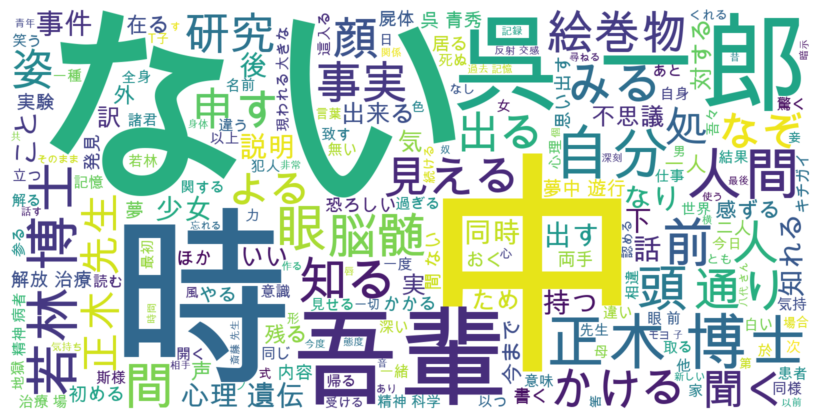

In [31]:
include_pos = ("NOUN", "VERB", "ADJ", "PROPN")
stopwords = ("いる", "ある", "する", "なる", "いう", "来る", "見る", "御座る", "おる", "思う", "行く", "云う", "考える", "しまう", "得る", "わかる", #動詞のstopwords
             "事", "もの", "お", "よう", "つ", "ところ", "上", "御", "方", "うち", "まま", "者", "年", "手", "今", "大" ,"等" #名詞のstopwords
             )

words = [token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords]

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ワードクラウドの表示設定と作成
wordcloud = WordCloud(
    width=1600, height=800,
    background_color="white", font_path=fpath
).generate(' '.join(words))

# プロット
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("wordcloud_assignment1.png", dpi=300)
plt.show()

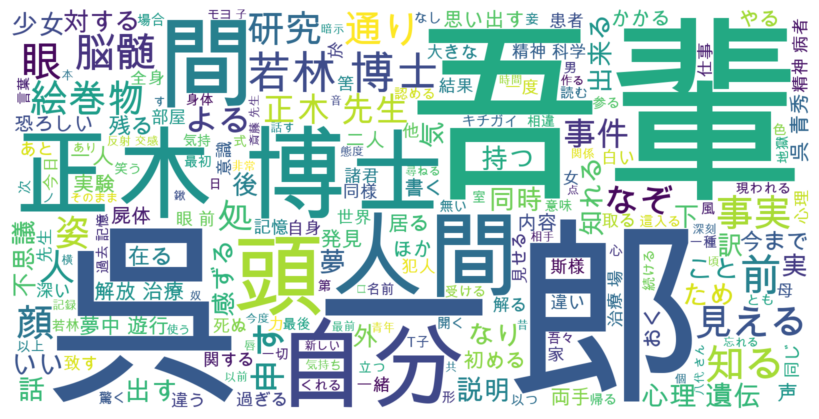

In [34]:
include_pos = ("NOUN", "VERB", "ADJ", "PROPN")
stopwords = ("いる", "ある", "する", "なる", "いう", "来る", "見る", "御座る", "おる", "思う", "行く", "云う", "考える", "しまう", "得る", "わかる", #動詞のstopwords
             "事", "もの", "お", "よう", "つ", "ところ", "上", "御", "方", "うち", "まま", "者", "年", "手", "今", "大" ,"等", #名詞のstopwords
             "ない", "時", "みる", "かける", "出る", "聞く", "中" # 1つ上のWCの結果を見て削除したもの
             )

words = [token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords]

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ワードクラウドの表示設定と作成
wordcloud = WordCloud(
    width=1600, height=800,
    background_color="white", font_path=fpath
).generate(' '.join(words))

# プロット
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("wordcloud_assignment2.png", dpi=300)
plt.show()

◾︎単語の出現頻度のランキングから言えそうなこと
- 多いのは「」「」「」
  - 「」は
  - 「」は
  - 「」は
- 少ないけどキーワードっぽいのは「」「」「」 
  - 「」は
  - 「」は
  - 「」は

◾︎WCから言えそうなこと
- aaa
- aaa
- aaa
  
それを踏まえて，登場人物間の関係性とキーワードのような言葉と別の単語との共起関係を可視化


## 何をやるかの雑多なブレストのメモ
- これまでの講義で面白そうに感じたこと
  - altairでの手続きを記述していくことでの可視化
  - spacyでテキストを処理して，それを可視化すること
  - -->面白そうに感じたことをさらに身につけるために使ってみる
    - 今回はテキストの可視化をしよう．1to1マーケを行う際のペルソナ描画にも使えそうな気がする．

- 可視化の際の問いの設定
  - お手本である演習のファイルを参考にするなら，青空文庫など適当な著作権切れの小説の内容の可視化+そこから言えることを見つけていく → 見つけていく中で主張をクリアにするための仮説構築と提示すべき情報の取捨選択を繰り返していけば良いのか．
    - 青空文庫の中で，目についた本かつ（読んだことはないが）内容をうっすら知っている本が良い
      - 内容を全く知らない場合にも限られた時間の範囲で読めるくらいの分量の本が良いね
        - https://search.bungo.app/authors/296/categories/short/books/46734
          - ↑とかは教育学っぽくて面白そう
          - 論拠の整理と著者の使う単語・コロケーションの癖とかみる？
            - 癖を見るためには1文献だけだとサンプルサイズ少なすぎて何も言えないでしょ，，
- 講義の中で引き合いに出てきたデータ可視化のプロセス（参考）
  - https://infovis.zhuxinru.com/images/week_10/dataviz_process.png
